In [1]:

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing.image import ImageDataGenerator


from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.per_process_gpu_memory_fraction = 0.55
K.set_session(K.tf.Session(config=cfg))
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical


from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.55
sess = tf.Session(config=config)
import random as rn


import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


# Data load

In [ ]:
from numba import cuda
cuda.current_context().reset()
sess.close() # if don't use numba,the gpu can't be released
cuda.select_device(0)
cuda.close()

In [16]:
X=[]
Z=[]
IMG_SIZE=150
FREE_DIR='C:/Users/Cloudyx/Downloads/Big Data Content Project/Comb/free'
FULL_DIR='C:/Users/Cloudyx\Downloads/Big Data Content Project/Comb/busy'

In [17]:
def assign_label(img,label):
    return label

In [18]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,label)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [19]:
# make 'Free' data
make_train_data('Free',FREE_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 4182/4182 [00:08<00:00, 465.92it/s]


4182


In [20]:
# make 'Full' data
make_train_data('Full',FULL_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 8402/8402 [00:17<00:00, 472.97it/s]


12584


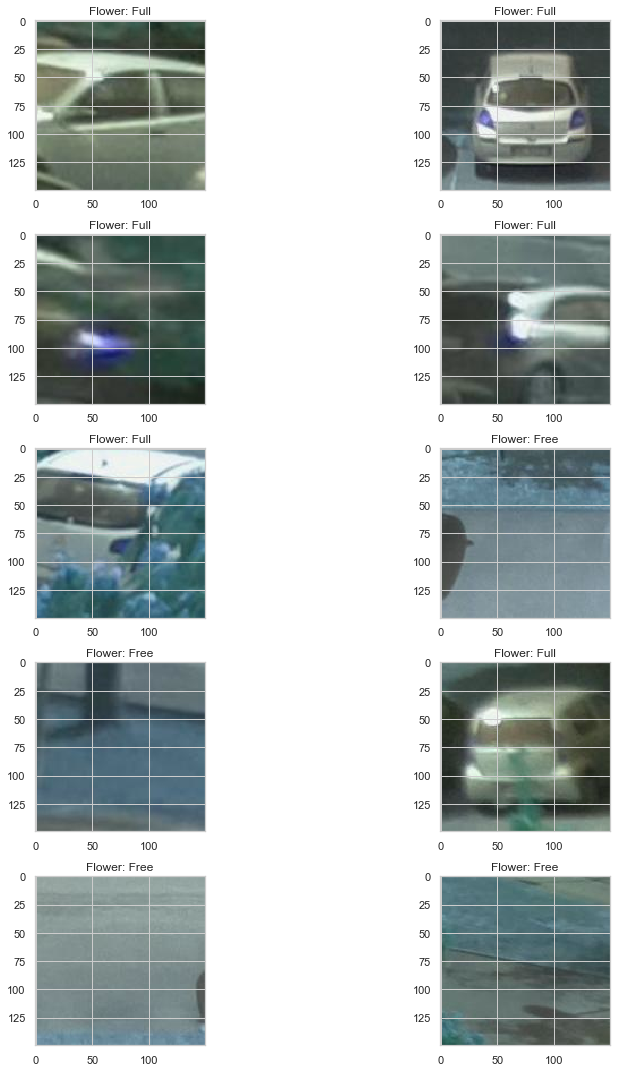

In [8]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [21]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [10]:

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [11]:

np.random.seed(432)
rn.seed(432)
tf.set_random_seed(432)

# Build model

In [12]:
#CNN

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation = "softmax"))

W0809 21:02:57.923144 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 21:02:57.999120 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 21:02:58.775935 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 21:02:59.036012 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [13]:
batch_size=64
epochs=40


from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [14]:
# data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

W0809 21:03:13.536844 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 21:03:13.619425 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

# Train

In [17]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

W0809 21:03:17.216181 27920 deprecation.py:323] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0809 21:03:19.417825 27920 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/40
147/147 [==============================] - ETA: 15:04 - loss: 0.7110 - acc: 0.26 - ETA: 7:36 - loss: 0.7462 - acc: 0.4531 - ETA: 5:04 - loss: 0.7092 - acc: 0.531 - ETA: 3:48 - loss: 0.6784 - acc: 0.582 - ETA: 3:03 - loss: 0.6742 - acc: 0.606 - ETA: 2:33 - loss: 0.6519 - acc: 0.632 - ETA: 2:11 - loss: 0.6465 - acc: 0.633 - ETA: 1:55 - loss: 0.6367 - acc: 0.640 - ETA: 1:42 - loss: 0.6272 - acc: 0.644 - ETA: 1:32 - loss: 0.6189 - acc: 0.646 - ETA: 1:24 - loss: 0.6058 - acc: 0.659 - ETA: 1:17 - loss: 0.5990 - acc: 0.660 - ETA: 1:11 - loss: 0.5903 - acc: 0.665 - ETA: 1:06 - loss: 0.5830 - acc: 0.667 - ETA: 1:01 - loss: 0.5742 - acc: 0.666 - ETA: 59s - loss: 0.5653 - acc: 0.668 - ETA: 57s - loss: 0.5592 - acc: 0.67 - ETA: 55s - loss: 0.5529 - acc: 0.67 - ETA: 53s - loss: 0.5404 - acc: 0.68 - ETA: 52s - loss: 0.5537 - acc: 0.68 - ETA: 50s - loss: 0.5471 - acc: 0.69 - ETA: 49s - loss: 0.5494 - acc: 0.69 - ETA: 48s - loss: 0.5538 - acc: 0.68 - ETA: 47s - loss: 0.5517 - acc: 0.69 - ET

147/147 [==============================] - ETA: 9s - loss: 0.1431 - acc: 0.937 - ETA: 7s - loss: 0.1153 - acc: 0.952 - ETA: 8s - loss: 0.1276 - acc: 0.944 - ETA: 8s - loss: 0.1373 - acc: 0.940 - ETA: 8s - loss: 0.1492 - acc: 0.937 - ETA: 8s - loss: 0.1486 - acc: 0.939 - ETA: 8s - loss: 0.1566 - acc: 0.933 - ETA: 8s - loss: 0.1437 - acc: 0.940 - ETA: 8s - loss: 0.1400 - acc: 0.943 - ETA: 8s - loss: 0.1379 - acc: 0.943 - ETA: 8s - loss: 0.1387 - acc: 0.938 - ETA: 8s - loss: 0.1372 - acc: 0.940 - ETA: 8s - loss: 0.1463 - acc: 0.937 - ETA: 9s - loss: 0.1466 - acc: 0.935 - ETA: 10s - loss: 0.1436 - acc: 0.93 - ETA: 11s - loss: 0.1440 - acc: 0.93 - ETA: 12s - loss: 0.1542 - acc: 0.93 - ETA: 13s - loss: 0.1541 - acc: 0.93 - ETA: 14s - loss: 0.1566 - acc: 0.93 - ETA: 15s - loss: 0.1576 - acc: 0.93 - ETA: 15s - loss: 0.1630 - acc: 0.93 - ETA: 16s - loss: 0.1665 - acc: 0.92 - ETA: 16s - loss: 0.1678 - acc: 0.92 - ETA: 17s - loss: 0.1672 - acc: 0.92 - ETA: 17s - loss: 0.1685 - acc: 0.92 - ETA: 17

147/147 [==============================] - ETA: 10s - loss: 0.0699 - acc: 0.96 - ETA: 10s - loss: 0.0706 - acc: 0.96 - ETA: 9s - loss: 0.0677 - acc: 0.9740 - ETA: 8s - loss: 0.1114 - acc: 0.968 - ETA: 8s - loss: 0.1210 - acc: 0.958 - ETA: 8s - loss: 0.1211 - acc: 0.957 - ETA: 8s - loss: 0.1200 - acc: 0.952 - ETA: 8s - loss: 0.1229 - acc: 0.949 - ETA: 8s - loss: 0.1201 - acc: 0.951 - ETA: 8s - loss: 0.1146 - acc: 0.954 - ETA: 8s - loss: 0.1122 - acc: 0.956 - ETA: 9s - loss: 0.1081 - acc: 0.959 - ETA: 9s - loss: 0.1064 - acc: 0.959 - ETA: 9s - loss: 0.1003 - acc: 0.962 - ETA: 11s - loss: 0.0984 - acc: 0.96 - ETA: 12s - loss: 0.1066 - acc: 0.96 - ETA: 13s - loss: 0.1133 - acc: 0.96 - ETA: 14s - loss: 0.1162 - acc: 0.95 - ETA: 14s - loss: 0.1169 - acc: 0.95 - ETA: 15s - loss: 0.1197 - acc: 0.95 - ETA: 16s - loss: 0.1181 - acc: 0.95 - ETA: 16s - loss: 0.1230 - acc: 0.95 - ETA: 17s - loss: 0.1195 - acc: 0.95 - ETA: 17s - loss: 0.1170 - acc: 0.95 - ETA: 17s - loss: 0.1224 - acc: 0.95 - ETA: 1

147/147 [==============================] - ETA: 10s - loss: 0.1723 - acc: 0.93 - ETA: 10s - loss: 0.1172 - acc: 0.95 - ETA: 9s - loss: 0.1150 - acc: 0.9583 - ETA: 9s - loss: 0.1175 - acc: 0.953 - ETA: 9s - loss: 0.1049 - acc: 0.956 - ETA: 8s - loss: 0.1070 - acc: 0.950 - ETA: 8s - loss: 0.1006 - acc: 0.954 - ETA: 8s - loss: 0.1160 - acc: 0.950 - ETA: 8s - loss: 0.1118 - acc: 0.955 - ETA: 8s - loss: 0.1206 - acc: 0.954 - ETA: 8s - loss: 0.1185 - acc: 0.955 - ETA: 8s - loss: 0.1170 - acc: 0.955 - ETA: 9s - loss: 0.1181 - acc: 0.953 - ETA: 11s - loss: 0.1170 - acc: 0.95 - ETA: 12s - loss: 0.1232 - acc: 0.94 - ETA: 13s - loss: 0.1172 - acc: 0.95 - ETA: 14s - loss: 0.1146 - acc: 0.95 - ETA: 15s - loss: 0.1112 - acc: 0.95 - ETA: 15s - loss: 0.1100 - acc: 0.95 - ETA: 16s - loss: 0.1123 - acc: 0.95 - ETA: 16s - loss: 0.1107 - acc: 0.95 - ETA: 17s - loss: 0.1117 - acc: 0.95 - ETA: 17s - loss: 0.1083 - acc: 0.95 - ETA: 18s - loss: 0.1108 - acc: 0.95 - ETA: 18s - loss: 0.1119 - acc: 0.95 - ETA: 1

147/147 [==============================] - ETA: 9s - loss: 0.1122 - acc: 0.953 - ETA: 9s - loss: 0.1266 - acc: 0.945 - ETA: 9s - loss: 0.1004 - acc: 0.958 - ETA: 9s - loss: 0.0896 - acc: 0.960 - ETA: 9s - loss: 0.0882 - acc: 0.962 - ETA: 9s - loss: 0.0852 - acc: 0.963 - ETA: 9s - loss: 0.0969 - acc: 0.959 - ETA: 8s - loss: 0.0938 - acc: 0.961 - ETA: 8s - loss: 0.0889 - acc: 0.963 - ETA: 8s - loss: 0.0866 - acc: 0.965 - ETA: 8s - loss: 0.0822 - acc: 0.968 - ETA: 8s - loss: 0.0819 - acc: 0.968 - ETA: 8s - loss: 0.0803 - acc: 0.970 - ETA: 10s - loss: 0.0806 - acc: 0.97 - ETA: 11s - loss: 0.0782 - acc: 0.97 - ETA: 12s - loss: 0.0821 - acc: 0.97 - ETA: 13s - loss: 0.0813 - acc: 0.97 - ETA: 14s - loss: 0.0805 - acc: 0.97 - ETA: 15s - loss: 0.0780 - acc: 0.97 - ETA: 15s - loss: 0.0786 - acc: 0.97 - ETA: 16s - loss: 0.0775 - acc: 0.97 - ETA: 17s - loss: 0.0824 - acc: 0.96 - ETA: 17s - loss: 0.0824 - acc: 0.97 - ETA: 17s - loss: 0.0817 - acc: 0.96 - ETA: 18s - loss: 0.0814 - acc: 0.96 - ETA: 18

147/147 [==============================] - ETA: 9s - loss: 0.0173 - acc: 1.000 - ETA: 9s - loss: 0.0213 - acc: 0.992 - ETA: 9s - loss: 0.0406 - acc: 0.984 - ETA: 9s - loss: 0.0316 - acc: 0.988 - ETA: 9s - loss: 0.0353 - acc: 0.987 - ETA: 9s - loss: 0.0403 - acc: 0.984 - ETA: 9s - loss: 0.0591 - acc: 0.979 - ETA: 9s - loss: 0.0538 - acc: 0.982 - ETA: 9s - loss: 0.0529 - acc: 0.982 - ETA: 9s - loss: 0.0546 - acc: 0.979 - ETA: 9s - loss: 0.0563 - acc: 0.979 - ETA: 8s - loss: 0.0558 - acc: 0.979 - ETA: 9s - loss: 0.0565 - acc: 0.979 - ETA: 10s - loss: 0.0565 - acc: 0.97 - ETA: 12s - loss: 0.0540 - acc: 0.98 - ETA: 13s - loss: 0.0567 - acc: 0.97 - ETA: 14s - loss: 0.0558 - acc: 0.97 - ETA: 14s - loss: 0.0581 - acc: 0.97 - ETA: 15s - loss: 0.0561 - acc: 0.98 - ETA: 16s - loss: 0.0547 - acc: 0.98 - ETA: 16s - loss: 0.0557 - acc: 0.97 - ETA: 17s - loss: 0.0585 - acc: 0.97 - ETA: 17s - loss: 0.0566 - acc: 0.97 - ETA: 17s - loss: 0.0568 - acc: 0.97 - ETA: 18s - loss: 0.0570 - acc: 0.97 - ETA: 18

147/147 [==============================] - ETA: 9s - loss: 0.0666 - acc: 0.968 - ETA: 10s - loss: 0.0607 - acc: 0.96 - ETA: 9s - loss: 0.0466 - acc: 0.9792 - ETA: 9s - loss: 0.0389 - acc: 0.984 - ETA: 9s - loss: 0.0598 - acc: 0.971 - ETA: 9s - loss: 0.0648 - acc: 0.971 - ETA: 9s - loss: 0.0619 - acc: 0.973 - ETA: 9s - loss: 0.0679 - acc: 0.968 - ETA: 9s - loss: 0.0776 - acc: 0.970 - ETA: 9s - loss: 0.0766 - acc: 0.971 - ETA: 9s - loss: 0.0769 - acc: 0.971 - ETA: 8s - loss: 0.0783 - acc: 0.972 - ETA: 8s - loss: 0.0743 - acc: 0.973 - ETA: 9s - loss: 0.0796 - acc: 0.971 - ETA: 11s - loss: 0.0791 - acc: 0.97 - ETA: 12s - loss: 0.0817 - acc: 0.97 - ETA: 13s - loss: 0.0801 - acc: 0.97 - ETA: 14s - loss: 0.0772 - acc: 0.97 - ETA: 15s - loss: 0.0760 - acc: 0.97 - ETA: 15s - loss: 0.0763 - acc: 0.97 - ETA: 16s - loss: 0.0783 - acc: 0.97 - ETA: 16s - loss: 0.0784 - acc: 0.97 - ETA: 17s - loss: 0.0763 - acc: 0.97 - ETA: 17s - loss: 0.0748 - acc: 0.97 - ETA: 17s - loss: 0.0726 - acc: 0.97 - ETA: 1

147/147 [==============================] - ETA: 9s - loss: 0.0264 - acc: 1.000 - ETA: 9s - loss: 0.0215 - acc: 1.000 - ETA: 9s - loss: 0.0244 - acc: 0.994 - ETA: 9s - loss: 0.0464 - acc: 0.988 - ETA: 10s - loss: 0.0441 - acc: 0.98 - ETA: 10s - loss: 0.0420 - acc: 0.98 - ETA: 9s - loss: 0.0434 - acc: 0.9866 - ETA: 9s - loss: 0.0408 - acc: 0.986 - ETA: 9s - loss: 0.0430 - acc: 0.982 - ETA: 9s - loss: 0.0450 - acc: 0.981 - ETA: 9s - loss: 0.0442 - acc: 0.981 - ETA: 9s - loss: 0.0426 - acc: 0.981 - ETA: 9s - loss: 0.0411 - acc: 0.983 - ETA: 10s - loss: 0.0404 - acc: 0.98 - ETA: 11s - loss: 0.0403 - acc: 0.98 - ETA: 13s - loss: 0.0468 - acc: 0.98 - ETA: 13s - loss: 0.0472 - acc: 0.98 - ETA: 14s - loss: 0.0469 - acc: 0.98 - ETA: 15s - loss: 0.0464 - acc: 0.98 - ETA: 16s - loss: 0.0512 - acc: 0.98 - ETA: 16s - loss: 0.0492 - acc: 0.98 - ETA: 17s - loss: 0.0475 - acc: 0.98 - ETA: 17s - loss: 0.0462 - acc: 0.98 - ETA: 17s - loss: 0.0458 - acc: 0.98 - ETA: 18s - loss: 0.0446 - acc: 0.98 - ETA: 1

147/147 [==============================] - ETA: 10s - loss: 0.0057 - acc: 1.00 - ETA: 10s - loss: 0.0443 - acc: 0.98 - ETA: 9s - loss: 0.0382 - acc: 0.9844 - ETA: 9s - loss: 0.0485 - acc: 0.980 - ETA: 9s - loss: 0.0451 - acc: 0.981 - ETA: 9s - loss: 0.0509 - acc: 0.979 - ETA: 9s - loss: 0.0469 - acc: 0.982 - ETA: 9s - loss: 0.0503 - acc: 0.978 - ETA: 9s - loss: 0.0464 - acc: 0.980 - ETA: 9s - loss: 0.0481 - acc: 0.978 - ETA: 9s - loss: 0.0439 - acc: 0.980 - ETA: 9s - loss: 0.0430 - acc: 0.980 - ETA: 9s - loss: 0.0415 - acc: 0.980 - ETA: 11s - loss: 0.0407 - acc: 0.98 - ETA: 12s - loss: 0.0437 - acc: 0.97 - ETA: 12s - loss: 0.0419 - acc: 0.98 - ETA: 14s - loss: 0.0399 - acc: 0.98 - ETA: 14s - loss: 0.0423 - acc: 0.98 - ETA: 15s - loss: 0.0436 - acc: 0.98 - ETA: 16s - loss: 0.0444 - acc: 0.97 - ETA: 16s - loss: 0.0442 - acc: 0.97 - ETA: 17s - loss: 0.0428 - acc: 0.98 - ETA: 17s - loss: 0.0419 - acc: 0.98 - ETA: 18s - loss: 0.0422 - acc: 0.98 - ETA: 18s - loss: 0.0407 - acc: 0.98 - ETA: 1

147/147 [==============================] - ETA: 9s - loss: 0.0379 - acc: 0.984 - ETA: 9s - loss: 0.0280 - acc: 0.992 - ETA: 9s - loss: 0.0347 - acc: 0.984 - ETA: 9s - loss: 0.0417 - acc: 0.980 - ETA: 9s - loss: 0.0654 - acc: 0.975 - ETA: 9s - loss: 0.0634 - acc: 0.976 - ETA: 9s - loss: 0.0743 - acc: 0.966 - ETA: 9s - loss: 0.0715 - acc: 0.968 - ETA: 9s - loss: 0.0639 - acc: 0.972 - ETA: 9s - loss: 0.0606 - acc: 0.973 - ETA: 9s - loss: 0.0568 - acc: 0.975 - ETA: 9s - loss: 0.0558 - acc: 0.976 - ETA: 9s - loss: 0.0582 - acc: 0.976 - ETA: 9s - loss: 0.0566 - acc: 0.976 - ETA: 10s - loss: 0.0537 - acc: 0.97 - ETA: 12s - loss: 0.0527 - acc: 0.97 - ETA: 13s - loss: 0.0522 - acc: 0.97 - ETA: 13s - loss: 0.0498 - acc: 0.98 - ETA: 14s - loss: 0.0526 - acc: 0.97 - ETA: 14s - loss: 0.0527 - acc: 0.97 - ETA: 15s - loss: 0.0504 - acc: 0.97 - ETA: 16s - loss: 0.0500 - acc: 0.98 - ETA: 16s - loss: 0.0480 - acc: 0.98 - ETA: 17s - loss: 0.0484 - acc: 0.97 - ETA: 17s - loss: 0.0479 - acc: 0.98 - ETA: 17

147/147 [==============================] - ETA: 8s - loss: 0.0610 - acc: 0.968 - ETA: 8s - loss: 0.0420 - acc: 0.984 - ETA: 8s - loss: 0.0349 - acc: 0.989 - ETA: 8s - loss: 0.0441 - acc: 0.980 - ETA: 8s - loss: 0.0455 - acc: 0.981 - ETA: 8s - loss: 0.0430 - acc: 0.984 - ETA: 8s - loss: 0.0374 - acc: 0.986 - ETA: 8s - loss: 0.0350 - acc: 0.988 - ETA: 8s - loss: 0.0366 - acc: 0.987 - ETA: 8s - loss: 0.0476 - acc: 0.985 - ETA: 8s - loss: 0.0455 - acc: 0.985 - ETA: 7s - loss: 0.0420 - acc: 0.987 - ETA: 9s - loss: 0.0401 - acc: 0.988 - ETA: 11s - loss: 0.0402 - acc: 0.98 - ETA: 12s - loss: 0.0411 - acc: 0.98 - ETA: 13s - loss: 0.0394 - acc: 0.98 - ETA: 14s - loss: 0.0384 - acc: 0.98 - ETA: 15s - loss: 0.0367 - acc: 0.98 - ETA: 16s - loss: 0.0436 - acc: 0.98 - ETA: 15s - loss: 0.0418 - acc: 0.98 - ETA: 16s - loss: 0.0412 - acc: 0.98 - ETA: 17s - loss: 0.0412 - acc: 0.98 - ETA: 17s - loss: 0.0423 - acc: 0.98 - ETA: 18s - loss: 0.0410 - acc: 0.98 - ETA: 18s - loss: 0.0401 - acc: 0.98 - ETA: 18

147/147 [==============================] - ETA: 8s - loss: 0.0803 - acc: 0.968 - ETA: 8s - loss: 0.0465 - acc: 0.984 - ETA: 8s - loss: 0.0517 - acc: 0.979 - ETA: 8s - loss: 0.0471 - acc: 0.980 - ETA: 8s - loss: 0.0473 - acc: 0.981 - ETA: 7s - loss: 0.0429 - acc: 0.981 - ETA: 7s - loss: 0.0434 - acc: 0.979 - ETA: 7s - loss: 0.0392 - acc: 0.982 - ETA: 7s - loss: 0.0370 - acc: 0.984 - ETA: 7s - loss: 0.0350 - acc: 0.985 - ETA: 7s - loss: 0.0348 - acc: 0.985 - ETA: 9s - loss: 0.0346 - acc: 0.985 - ETA: 10s - loss: 0.0342 - acc: 0.98 - ETA: 12s - loss: 0.0331 - acc: 0.98 - ETA: 13s - loss: 0.0320 - acc: 0.98 - ETA: 14s - loss: 0.0313 - acc: 0.98 - ETA: 15s - loss: 0.0302 - acc: 0.98 - ETA: 16s - loss: 0.0316 - acc: 0.98 - ETA: 16s - loss: 0.0305 - acc: 0.98 - ETA: 17s - loss: 0.0326 - acc: 0.98 - ETA: 18s - loss: 0.0312 - acc: 0.98 - ETA: 17s - loss: 0.0313 - acc: 0.98 - ETA: 18s - loss: 0.0308 - acc: 0.98 - ETA: 18s - loss: 0.0319 - acc: 0.98 - ETA: 18s - loss: 0.0309 - acc: 0.98 - ETA: 19

147/147 [==============================] - ETA: 10s - loss: 0.0383 - acc: 0.98 - ETA: 10s - loss: 0.0233 - acc: 0.99 - ETA: 9s - loss: 0.0245 - acc: 0.9896 - ETA: 9s - loss: 0.0205 - acc: 0.992 - ETA: 9s - loss: 0.0206 - acc: 0.990 - ETA: 8s - loss: 0.0196 - acc: 0.992 - ETA: 8s - loss: 0.0184 - acc: 0.993 - ETA: 9s - loss: 0.0404 - acc: 0.990 - ETA: 9s - loss: 0.0361 - acc: 0.991 - ETA: 8s - loss: 0.0403 - acc: 0.990 - ETA: 8s - loss: 0.0368 - acc: 0.991 - ETA: 8s - loss: 0.0354 - acc: 0.990 - ETA: 8s - loss: 0.0331 - acc: 0.991 - ETA: 10s - loss: 0.0313 - acc: 0.99 - ETA: 11s - loss: 0.0321 - acc: 0.99 - ETA: 12s - loss: 0.0374 - acc: 0.98 - ETA: 13s - loss: 0.0385 - acc: 0.98 - ETA: 14s - loss: 0.0370 - acc: 0.98 - ETA: 15s - loss: 0.0367 - acc: 0.98 - ETA: 16s - loss: 0.0369 - acc: 0.98 - ETA: 16s - loss: 0.0404 - acc: 0.98 - ETA: 17s - loss: 0.0397 - acc: 0.98 - ETA: 17s - loss: 0.0382 - acc: 0.98 - ETA: 17s - loss: 0.0405 - acc: 0.98 - ETA: 17s - loss: 0.0417 - acc: 0.98 - ETA: 1

147/147 [==============================] - ETA: 8s - loss: 0.0341 - acc: 0.984 - ETA: 8s - loss: 0.0181 - acc: 0.992 - ETA: 8s - loss: 0.0153 - acc: 0.994 - ETA: 8s - loss: 0.0163 - acc: 0.992 - ETA: 8s - loss: 0.0154 - acc: 0.993 - ETA: 8s - loss: 0.0171 - acc: 0.992 - ETA: 8s - loss: 0.0164 - acc: 0.993 - ETA: 8s - loss: 0.0154 - acc: 0.994 - ETA: 8s - loss: 0.0149 - acc: 0.994 - ETA: 8s - loss: 0.0150 - acc: 0.993 - ETA: 8s - loss: 0.0166 - acc: 0.992 - ETA: 8s - loss: 0.0156 - acc: 0.993 - ETA: 9s - loss: 0.0146 - acc: 0.994 - ETA: 10s - loss: 0.0195 - acc: 0.99 - ETA: 12s - loss: 0.0185 - acc: 0.99 - ETA: 13s - loss: 0.0208 - acc: 0.99 - ETA: 14s - loss: 0.0237 - acc: 0.99 - ETA: 15s - loss: 0.0229 - acc: 0.99 - ETA: 15s - loss: 0.0223 - acc: 0.99 - ETA: 16s - loss: 0.0240 - acc: 0.99 - ETA: 17s - loss: 0.0236 - acc: 0.99 - ETA: 17s - loss: 0.0232 - acc: 0.99 - ETA: 18s - loss: 0.0224 - acc: 0.99 - ETA: 18s - loss: 0.0232 - acc: 0.99 - ETA: 18s - loss: 0.0224 - acc: 0.99 - ETA: 18

147/147 [==============================] - ETA: 9s - loss: 0.0431 - acc: 0.984 - ETA: 9s - loss: 0.0313 - acc: 0.992 - ETA: 9s - loss: 0.0369 - acc: 0.984 - ETA: 9s - loss: 0.0614 - acc: 0.980 - ETA: 9s - loss: 0.0500 - acc: 0.984 - ETA: 9s - loss: 0.0469 - acc: 0.984 - ETA: 9s - loss: 0.0408 - acc: 0.986 - ETA: 9s - loss: 0.0389 - acc: 0.986 - ETA: 9s - loss: 0.0352 - acc: 0.987 - ETA: 9s - loss: 0.0323 - acc: 0.989 - ETA: 9s - loss: 0.0441 - acc: 0.985 - ETA: 9s - loss: 0.0409 - acc: 0.987 - ETA: 9s - loss: 0.0391 - acc: 0.988 - ETA: 10s - loss: 0.0414 - acc: 0.98 - ETA: 12s - loss: 0.0403 - acc: 0.98 - ETA: 13s - loss: 0.0379 - acc: 0.98 - ETA: 14s - loss: 0.0433 - acc: 0.98 - ETA: 15s - loss: 0.0418 - acc: 0.98 - ETA: 15s - loss: 0.0432 - acc: 0.98 - ETA: 16s - loss: 0.0415 - acc: 0.98 - ETA: 17s - loss: 0.0404 - acc: 0.98 - ETA: 17s - loss: 0.0390 - acc: 0.98 - ETA: 18s - loss: 0.0375 - acc: 0.98 - ETA: 18s - loss: 0.0379 - acc: 0.98 - ETA: 18s - loss: 0.0376 - acc: 0.98 - ETA: 19

147/147 [==============================] - ETA: 8s - loss: 0.0075 - acc: 1.000 - ETA: 9s - loss: 0.0105 - acc: 1.000 - ETA: 9s - loss: 0.0249 - acc: 0.989 - ETA: 9s - loss: 0.0298 - acc: 0.984 - ETA: 8s - loss: 0.0256 - acc: 0.987 - ETA: 8s - loss: 0.0278 - acc: 0.987 - ETA: 8s - loss: 0.0543 - acc: 0.979 - ETA: 8s - loss: 0.0496 - acc: 0.982 - ETA: 8s - loss: 0.0541 - acc: 0.980 - ETA: 8s - loss: 0.0648 - acc: 0.979 - ETA: 8s - loss: 0.0602 - acc: 0.981 - ETA: 8s - loss: 0.0649 - acc: 0.979 - ETA: 9s - loss: 0.0601 - acc: 0.980 - ETA: 11s - loss: 0.0567 - acc: 0.98 - ETA: 12s - loss: 0.0532 - acc: 0.98 - ETA: 13s - loss: 0.0512 - acc: 0.98 - ETA: 14s - loss: 0.0492 - acc: 0.98 - ETA: 15s - loss: 0.0468 - acc: 0.98 - ETA: 16s - loss: 0.0450 - acc: 0.98 - ETA: 16s - loss: 0.0459 - acc: 0.98 - ETA: 17s - loss: 0.0448 - acc: 0.98 - ETA: 17s - loss: 0.0433 - acc: 0.98 - ETA: 18s - loss: 0.0429 - acc: 0.98 - ETA: 18s - loss: 0.0412 - acc: 0.98 - ETA: 18s - loss: 0.0400 - acc: 0.98 - ETA: 19

147/147 [==============================] - ETA: 9s - loss: 0.0689 - acc: 0.984 - ETA: 9s - loss: 0.0383 - acc: 0.992 - ETA: 9s - loss: 0.0261 - acc: 0.994 - ETA: 9s - loss: 0.0217 - acc: 0.996 - ETA: 9s - loss: 0.0225 - acc: 0.993 - ETA: 9s - loss: 0.0286 - acc: 0.992 - ETA: 9s - loss: 0.0280 - acc: 0.991 - ETA: 9s - loss: 0.0277 - acc: 0.990 - ETA: 9s - loss: 0.0276 - acc: 0.989 - ETA: 9s - loss: 0.0261 - acc: 0.990 - ETA: 9s - loss: 0.0286 - acc: 0.990 - ETA: 9s - loss: 0.0305 - acc: 0.988 - ETA: 9s - loss: 0.0284 - acc: 0.989 - ETA: 11s - loss: 0.0271 - acc: 0.99 - ETA: 12s - loss: 0.0319 - acc: 0.98 - ETA: 13s - loss: 0.0337 - acc: 0.98 - ETA: 14s - loss: 0.0319 - acc: 0.98 - ETA: 15s - loss: 0.0302 - acc: 0.98 - ETA: 16s - loss: 0.0306 - acc: 0.98 - ETA: 16s - loss: 0.0312 - acc: 0.98 - ETA: 17s - loss: 0.0307 - acc: 0.98 - ETA: 17s - loss: 0.0301 - acc: 0.98 - ETA: 18s - loss: 0.0289 - acc: 0.98 - ETA: 18s - loss: 0.0355 - acc: 0.98 - ETA: 19s - loss: 0.0342 - acc: 0.98 - ETA: 19

147/147 [==============================] - ETA: 8s - loss: 0.0361 - acc: 0.984 - ETA: 8s - loss: 0.0428 - acc: 0.984 - ETA: 8s - loss: 0.0295 - acc: 0.989 - ETA: 8s - loss: 0.0279 - acc: 0.988 - ETA: 8s - loss: 0.0256 - acc: 0.990 - ETA: 8s - loss: 0.0215 - acc: 0.992 - ETA: 8s - loss: 0.0213 - acc: 0.991 - ETA: 8s - loss: 0.0217 - acc: 0.990 - ETA: 8s - loss: 0.0220 - acc: 0.989 - ETA: 8s - loss: 0.0214 - acc: 0.990 - ETA: 8s - loss: 0.0234 - acc: 0.990 - ETA: 8s - loss: 0.0241 - acc: 0.989 - ETA: 8s - loss: 0.0242 - acc: 0.989 - ETA: 10s - loss: 0.0319 - acc: 0.98 - ETA: 11s - loss: 0.0305 - acc: 0.98 - ETA: 12s - loss: 0.0370 - acc: 0.98 - ETA: 13s - loss: 0.0350 - acc: 0.98 - ETA: 14s - loss: 0.0390 - acc: 0.98 - ETA: 15s - loss: 0.0434 - acc: 0.98 - ETA: 16s - loss: 0.0413 - acc: 0.98 - ETA: 16s - loss: 0.0406 - acc: 0.98 - ETA: 17s - loss: 0.0391 - acc: 0.98 - ETA: 17s - loss: 0.0414 - acc: 0.98 - ETA: 18s - loss: 0.0408 - acc: 0.98 - ETA: 18s - loss: 0.0392 - acc: 0.98 - ETA: 18

147/147 [==============================] - ETA: 8s - loss: 0.0084 - acc: 1.000 - ETA: 8s - loss: 0.0451 - acc: 0.984 - ETA: 8s - loss: 0.0310 - acc: 0.989 - ETA: 8s - loss: 0.0336 - acc: 0.984 - ETA: 8s - loss: 0.0303 - acc: 0.984 - ETA: 8s - loss: 0.0289 - acc: 0.984 - ETA: 8s - loss: 0.0248 - acc: 0.986 - ETA: 8s - loss: 0.0254 - acc: 0.986 - ETA: 8s - loss: 0.0253 - acc: 0.986 - ETA: 8s - loss: 0.0242 - acc: 0.987 - ETA: 8s - loss: 0.0370 - acc: 0.987 - ETA: 8s - loss: 0.0345 - acc: 0.988 - ETA: 9s - loss: 0.0320 - acc: 0.989 - ETA: 11s - loss: 0.0333 - acc: 0.98 - ETA: 12s - loss: 0.0312 - acc: 0.98 - ETA: 13s - loss: 0.0294 - acc: 0.99 - ETA: 14s - loss: 0.0285 - acc: 0.98 - ETA: 15s - loss: 0.0272 - acc: 0.99 - ETA: 16s - loss: 0.0259 - acc: 0.99 - ETA: 16s - loss: 0.0247 - acc: 0.99 - ETA: 17s - loss: 0.0239 - acc: 0.99 - ETA: 17s - loss: 0.0249 - acc: 0.99 - ETA: 18s - loss: 0.0249 - acc: 0.99 - ETA: 18s - loss: 0.0242 - acc: 0.99 - ETA: 18s - loss: 0.0236 - acc: 0.99 - ETA: 19

147/147 [==============================] - ETA: 8s - loss: 0.0104 - acc: 1.000 - ETA: 8s - loss: 0.0502 - acc: 0.984 - ETA: 8s - loss: 0.0463 - acc: 0.984 - ETA: 8s - loss: 0.0407 - acc: 0.984 - ETA: 8s - loss: 0.0333 - acc: 0.987 - ETA: 8s - loss: 0.0293 - acc: 0.989 - ETA: 8s - loss: 0.0292 - acc: 0.988 - ETA: 8s - loss: 0.0275 - acc: 0.988 - ETA: 8s - loss: 0.0249 - acc: 0.989 - ETA: 8s - loss: 0.0328 - acc: 0.989 - ETA: 8s - loss: 0.0300 - acc: 0.990 - ETA: 8s - loss: 0.0321 - acc: 0.989 - ETA: 9s - loss: 0.0299 - acc: 0.990 - ETA: 10s - loss: 0.0353 - acc: 0.99 - ETA: 12s - loss: 0.0349 - acc: 0.99 - ETA: 13s - loss: 0.0333 - acc: 0.99 - ETA: 14s - loss: 0.0319 - acc: 0.99 - ETA: 15s - loss: 0.0330 - acc: 0.99 - ETA: 15s - loss: 0.0331 - acc: 0.99 - ETA: 16s - loss: 0.0321 - acc: 0.99 - ETA: 17s - loss: 0.0313 - acc: 0.99 - ETA: 17s - loss: 0.0299 - acc: 0.99 - ETA: 18s - loss: 0.0292 - acc: 0.99 - ETA: 18s - loss: 0.0282 - acc: 0.99 - ETA: 18s - loss: 0.0276 - acc: 0.99 - ETA: 18

In [19]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

# Evaluate model

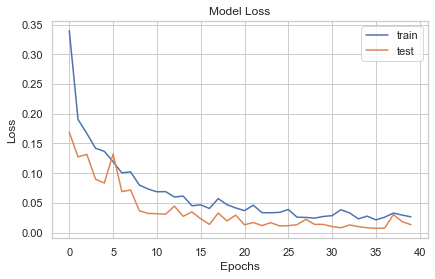

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

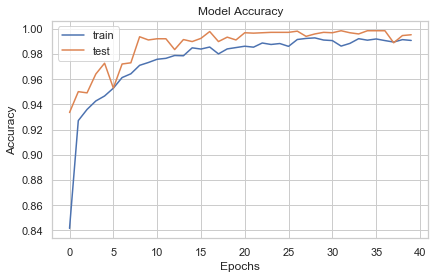

In [21]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [22]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [23]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

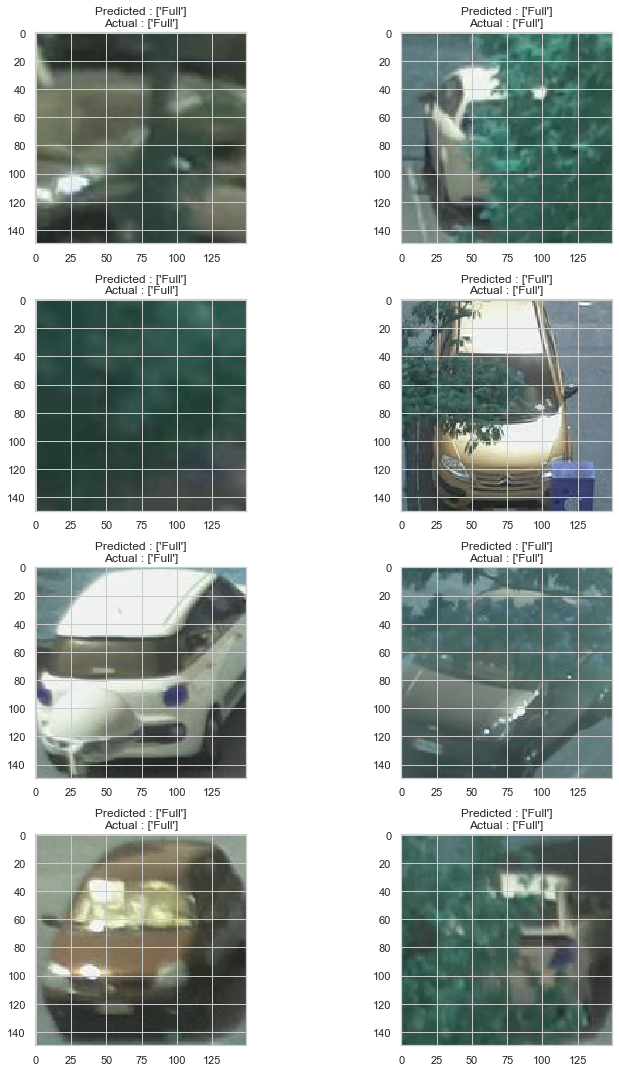

In [24]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

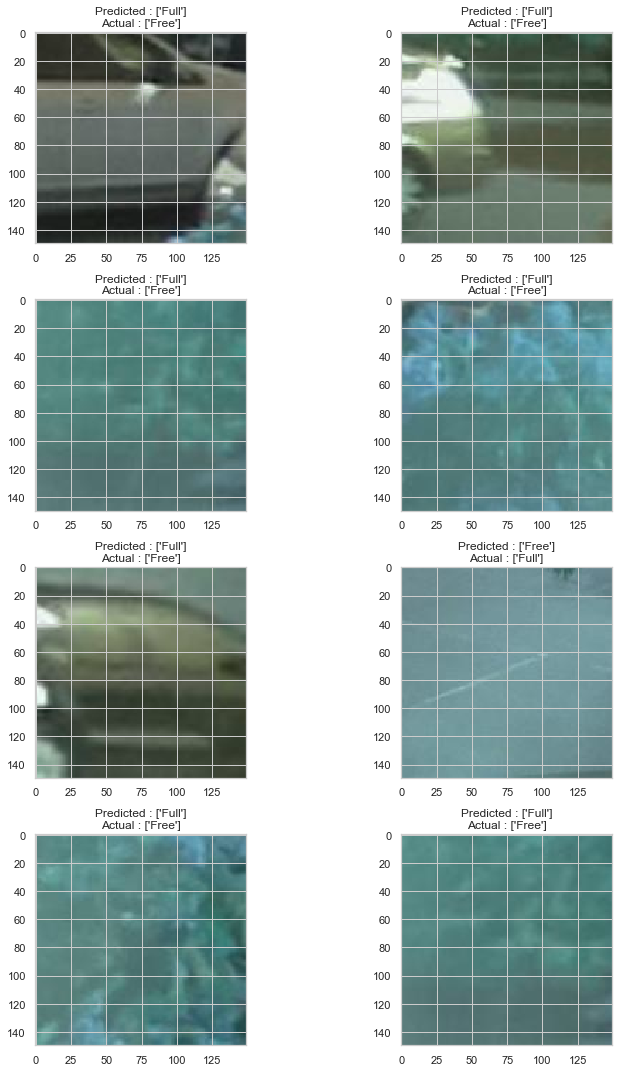

In [25]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

In [2]:
from keras.models import load_model
model = load_model('my_model.h5')

W0903 20:17:22.076199 49640 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 20:17:22.079198 49640 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 20:17:22.090194 49640 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0903 20:17:22.173167 49640 deprecation_wrapper.py:119] From d:\applications\anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 20:17:22.175167 4964

In [6]:
from keras.preprocessing import image
batch_holder = np.zeros((665, 150, 150, 3))
img_dir='C:/Users/Cloudyx/Downloads/Big Data Content Project/PATCHES/OVERCAST/2015-11-16/camera1'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(150,150))
  batch_holder[i, :] = img

In [8]:
rpred=model.predict(batch_holder)
rpred_digits=np.argmax(rpred,axis=1)

In [22]:
str(le.inverse_transform([rpred_digits[0]]))

"['Full']"

ValueError: num must be 1 <= num <= 20, not 21

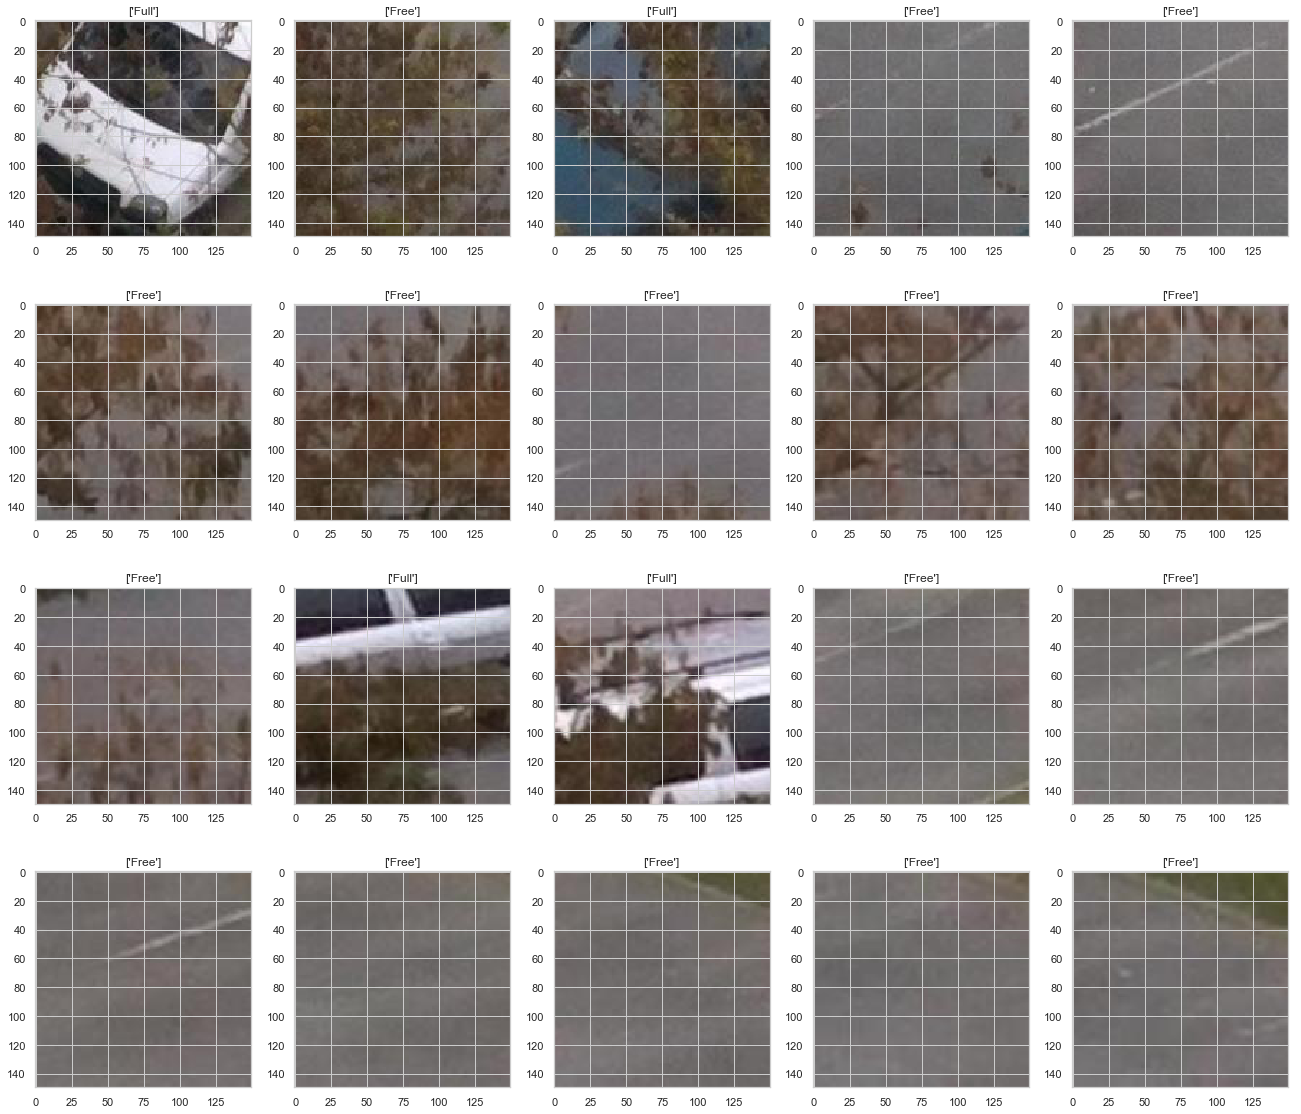

In [26]:
fig = plt.figure(figsize=(20,20))
 
for i,img in enumerate(batch_holder):
    
    fig.add_subplot(4,5, i+1)
    plt.title(str(le.inverse_transform([rpred_digits[i]])))
    
    plt.imshow(img/256.)
  
plt.show()